 # Libraries Guide
* torch, nn, optim - used to define and train the (fuzzy) neural networks in PyTorch
* numpy - numerical operations (arrays, math, etc.)
* matplotlib - for visualizing results (loss curves, predictions)
* sklearn - dataset loading, preprocessing, and splitting

In [20]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas


## Binary Classification: Dataset 2

In [21]:
# CHOOSE DATASET

# Regression dataset
#data = datasets.load_diabetes(as_frame=True)

# Binary Classification dataset
data = datasets.fetch_openml(name="diabetes",version=1, as_frame=True) 

X = data.data.values     # Feature Assignement to variable X: (768 samples, 8 features)
y = data.target.values   # target assignment to varible Y: (768 samples, binary outcome: 0 = no diabetes, 1 = diabetes)

print(X.shape)    # Check dimensions X: should be (768, 8)
print(y.shape)    # Check dimensions Y: should be (768, ) - 1D array in numpy 

(768, 8)
(768,)


In [22]:
# Visualising first 5 rows of Dataset 2
data.data.head(5)

,preg,plas,pres,skin,insu,mass,pedi,age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [23]:
# Make sure y is numeric (0 = negative, 1 = positive)
from sklearn.preprocessing import LabelEncoder
y = LabelEncoder().fit_transform(y)

#train test spliting
test_size=0.2 # 20 % of data will be reserved for testing (or dev more apropriatly),and 80 % for training 
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

# Note: for comparisons is important to mantain both the train/test split and the seed (random_state) equal across models

In [24]:
# Standardize features
# Note: standardization ensures that all input variables contribute equally 
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)


# Fuzzy C-Means Clutering 
#### Arguments:
* Xexp_T - dataset (features x samples)
* n_clusters - number of clusters (fuzzy rules)
* m - fuzziness parameter
* error - stopping criterion (tolerance for convergence)
* maxiter - maximum number of iterations
* init=None - centers initialized randomly

#### Returns:
* centers - coordinates of cluster centers (one per rule)
* u - final fuzzy membership matrix (shape: n_clusters x samples)
* u0 - initial membership matrix
* d - final Euclidean distances between samples and centers
* jm - objective function history
* p - number of iterations run
* fpc - fuzzy partition coefficient (validity measure of clustering)
---
### Fuzzy C-Means (FCM) Formulas

**1. Membership degree update**

$$
u_{ij} = \frac{1}{\sum\limits_{k=1}^{c} \left( \frac{\|x_i - v_j\|}{\|x_i - v_k\|} \right)^{\frac{2}{m-1}} }
$$

where:  
- \( u_{ij} \in [0,1] \) = degree of membership of point \(x_i\) in cluster \(j\)  
- \( c \) = number of clusters  
- \( m > 1 \) = fuzziness exponent (controls how “soft” memberships are)  
- \( v_j \) = center of cluster \(j\)  
- \( \|\cdot\| \) = Euclidean distance  



**2. Cluster center update**

$$
v_j = \frac{\sum\limits_{i=1}^{N} \big(u_{ij}\big)^m \, x_i}{\sum\limits_{i=1}^{N} \big(u_{ij}\big)^m}
$$

where:  
- \( N \) = number of data points  
- \( (u_{ij})^m \) = membership degree raised to fuzziness \(m\), used as weight  



**3. Objective function**

$$
J_m = \sum_{i=1}^{N} \sum_{j=1}^{c} \big(u_{ij}\big)^m \, \|x_i - v_j\|^2
$$

FCM minimizes this objective function iteratively by updating memberships and cluster centers until convergence.

In [25]:
## Number of clusters 
n_clusters = 2  # Each cluster corresponds to one fuzzy rule in the TSK model
m = 2 # Controls how "soft" the clustering is:
# - Larger m more overlap bettwen clusters 
# - lower m clustering is harder (memberships closer to 0 or 1)

## Concatenate target for clustering
# This way, the clustering considers both input space (Xtr) and output (ytr)
# This helps place cluster centers in regions that capture input-output relations
Xexp=np.concatenate([Xtr, ytr.reshape(-1, 1)], axis=1)

# Transpose data for skfuzzy (expects features x samples)
Xexp_T = Xexp.T  # each row is one feature plus target

# Fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None,
)

In [26]:
centers.shape # Check the shape of the cluster centers matrix

(2, 9)

In [27]:
# Compute sigma (spread) for each cluster
sigmas = []
for j in range(n_clusters):
    # membership weights for cluster j, raised to m (fuzziness parameter)
    u_j = u[j, :] ** m 
    # weighted variance for each feature (ensures points with higher membership contribute more
    var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j) #(Xexp - centers[j])**2 squared distance for each sample to cluster center 
    sigma_j = np.sqrt(var_j)  # standard deviation
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)

Fuzzy partition coefficient (FPC): 0.5049351797528491


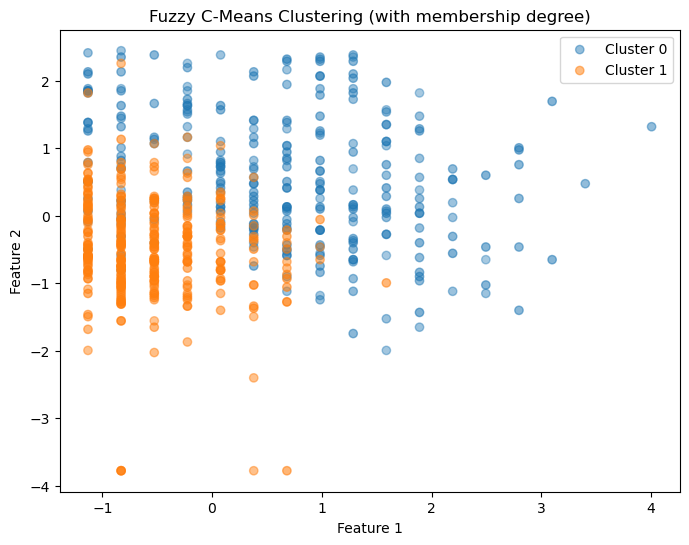

In [28]:
# === CLUSTER VISUALISATION === 

# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0) # Each sample is assigned to the cluster where it has the highest membership degree

# Note: FPC ∈ [0, 1], where:
#   - Values closer to 1 indicate well-defined, distinct clusters
#   - Values closer to 0 indicate poor clustering 
print("Fuzzy partition coefficient (FPC):", fpc)


# --- Plot first two features with fuzzy membership ---
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    # alpha = u[j,:] → transparency reflects membership degree:
    #   - strong membership:  darker color
    #   - weak membership : lighter color
    plt.scatter(
        Xexp[cluster_labels == j, 0],             # Feature 1
        Xexp[cluster_labels == j, 1],             # Feature 2
        alpha=u[j, :],          # transparency ~ membership
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (with membership degree)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

#### Plot 1 & FPC Comment 
* This is just slightly above the minimum (1/c = 0.5, for n=2)
* It means the clustering is very fuzzy: samples have almost equal membership in both clusters.
* The algorithm did not find well-separated groups in the data — instead, rules overlap heavily.



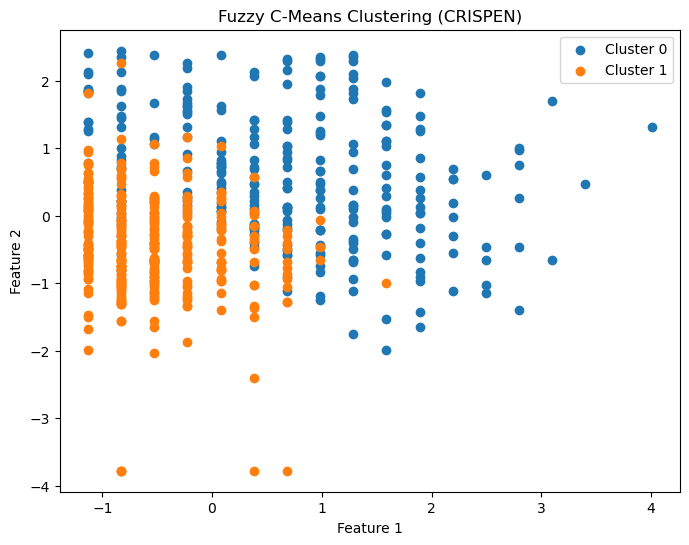

In [29]:
# Plot first two features with cluster assignments (crispened version)
plt.figure(figsize=(8,6))

for j in range(n_clusters):
    # Scatter plot of samples assigned to cluster j (hard clustering).
    # Unlike the previous fuzzy plot, here we ignore membership degrees (alpha),
    # and simply color points by their most likely cluster.
    plt.scatter(
        Xexp[cluster_labels == j, 0],  # Feature 1 
        Xexp[cluster_labels == j, 1],  # Feature 2 
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (CRISPEN)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

#### Plot 2: Results Comment 
As mentioned before, unlike the previous fuzzy plot, here we ignore membership degrees (alpha), and simply color points by their most likely cluster, explaining the absence of color gradients. 

# Gaussian Membership function
#### Inputs:
   - x: input values (vector)
   - mu: mean (center of the Gaussian, from clustering)
   - sigma: standard deviation (spread of the Gaussian, from clustering)
#### Output:
   - degree of membership ∈ [0, 1]

$$
\mu(x) = \exp\left(-\frac{1}{2}\left(\frac{x - \mu}{\sigma}\right)^2\right)
$$



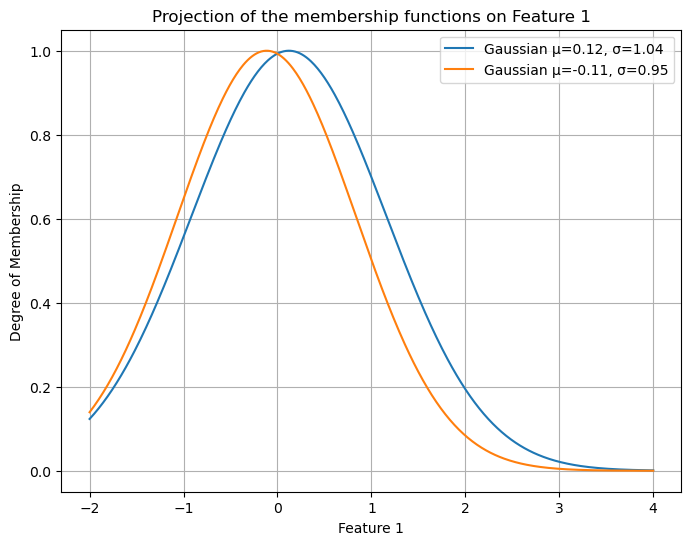

In [30]:
# Gaussian formula
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2)

# Generate a range of values for Feature 1 (x-axis of the plot).
# This will let us visualize the Gaussian curves for that feature
lin=np.linspace(-2, 4, 500)

plt.figure(figsize=(8,6))


y_aux=[]
for j in range(n_clusters):
    # Compute the Gaussian curve for cluster j on Feature 1.
    # centers[j,0] = mean of cluster j for Feature 1
    # sigmas[j,0] = spread of cluster j for Feature 1
    y_aux.append(gaussian(lin, centers[j,0], sigmas[j,0]))

# Plot Gaussian membership 
    plt.plot(lin, y_aux[j], label=f"Gaussian μ={np.round(centers[j,0],2)}, σ={np.round(sigmas[j,0],2)}")

plt.title("Projection of the membership functions on Feature 1")
plt.xlabel("Feature 1")
plt.ylabel("Degree of Membership")
plt.legend()
plt.grid(True)
plt.show()

#### Plot 2: Results Comment 

* The two means are almost equal in this case (0.11 - 0.12).
* The spreads (σ ≈ 0.9–1.0) are wide, which is expected because inputs were standardized (σ around 1 ≈ one standard deviation of the original feature).
* On Feature 1, the two rules have strong overlap, so this feature alone doesn’t discriminate the clusters/rules much.

 

In [31]:
# ---------------------------
# Gaussian Membership Function (Antecedents of fuzzy rules)
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        # Each Gaussian MF is defined by its center (μ) and spread (σ).
        # Both are learnable parameters initialized from clustering.
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))

        # Flag for aggregation type:
        # If True: use probabilistic (L2 norm) aggregation
        # If False: use max-distance (equivalent to fuzzy "min" operator)
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting (Broadcasting automatically expands tensors with singleton dimensions (size 1) 
        #so their shapes are compatible for mathematical operations)
        # x: (batch, n_inputs) → (batch, 1, n_inputs)
        # centers: (n_rules, n_inputs) → (1, n_rules, n_inputs)
        # sigmas: (n_rules, n_inputs) → (1, n_rules, n_inputs)
        diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)

        # Aggregation of distances across input dimensions
        if self.agg_prob:
            # Probabilistic aggregation: smoother intersection across features
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)

        # Final Gaussian membership degree (∈ [0,1])
        return torch.exp(-0.5 * dist ** 2)


# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)
        
        self.mfs=GaussianMF(centers, sigmas,agg_prob) 

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(
            torch.randn(n_inputs + 1,n_rules)    # Shape: (n_inputs+1, n_rules)
        )

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]
        
        # Step 1: Compute rule firing strengths via Gaussian MFs
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)
        
        # Step 2: Normalize firing strengths so they sum to 1 for each sample
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Step 3: Compute rule consequents (linear functions of inputs)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias 

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)

        # Step 4: Weighted sum of rule outputs by normalized firing strengths
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        # Return:
        # - output: final prediction
        # - norm_fs: normalized rule activations
        # - rule_outputs: per-rule consequent output
        return output, norm_fs, rule_outputs



In [32]:
# ---------------------------
# Least Squares Solver for Consequents (TSK)
# ---------------------------
def train_ls(model, X, y):
    # Disable gradient tracking: LS solution is closed-form, no need for backprop
    with torch.no_grad():
        _, norm_fs, _ = model(X) # norm_fs: (n_samples, n_rules)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)

        # Build the design matrix Φ:
        # For each sample, compute input × normalized firing strength per rule
        # einsum: "br" (samples × rules) × "bi" (samples × inputs) → "bri" (samples × rules × inputs)
        # Reshape → (n_samples, (n_rules * (n_inputs+1)))
        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)
        
        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y
        # Using PyTorch's built-in lstsq solver
        theta= torch.linalg.lstsq(Phi, y).solution
    
        # Reshape theta into (n_inputs+1, n_rules) and assign to model parameters
        model.consequents.data = theta.reshape(model.consequents.shape)

    


In [33]:
# ---------------------------
# Gradient Descent Training 
# ---------------------------
def train_gd(model, X, y, epochs=100, lr=1e-3):
    # Define optimizer: Adam
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Define loss function: Mean Squared Error (MSE) for regression
    criterion = nn.MSELoss()

    # Training Loop
    for _ in range(epochs):
        # Reset accumulated gradients from previous iteration
        optimizer.zero_grad()

        # Forward propagation: predict outputs from the model
        y_pred, _, _ = model(X)

         # Compute loss: mean squared error between predictions and targets
        loss = criterion(y_pred, y)
        print(loss) # to monitor convergence

        # Backward pass: compute gradients of loss of all trainable parameter
        loss.backward()

        # Parameter update: optimizer adjusts centers, sigmas, consequents
        optimizer.step()


In [34]:
# ---------------------------
# Hybrid Training (Classic ANFIS)
# ---------------------------
def train_hybrid_alternating(model, X, y, max_iters=10, gd_epochs=20, lr=1e-3):
    for _ in range(max_iters):
        # Step A: GD on antecedents (freeze consequents)
        for p in model.consequents.parameters():  
            p.requires_grad = False # consequents fixed
        train_gd(model, X, y, epochs=gd_epochs, lr=lr)

        # Step B: LS on consequents (freeze antecedents)
        for p in model.consequents.parameters():  
            p.requires_grad = True # consequents free again
        for p in model.mfs.parameters():
            p.requires_grad = False # antecedents frozen
        train_ls(model, X, y)

        # Re-enable antecedents for the nest iteration
        for p in model.mfs.parameters():
            p.requires_grad = True

In [35]:
# ---------------------------
# Alternative Hybrid Training (LS+ gradient descent on all)
# ---------------------------
def train_hybrid_classic(model, X, y, epochs=100, lr=1e-4):

    """
    Hybrid training strategy:
    1. Initialize consequents with a closed-form Least Squares solution.
    2. Fine-tune *all* parameters (antecedents + consequents) jointly 
       with gradient descent.
    """
    
    # Step 1: LS for consequents (w, b)
    train_ls(model, X, y)
    # Step 2: GD fine-tuning (μ, σ, w, b)
    train_gd(model, X, y, epochs=epochs, lr=lr)


In [36]:
# Build model
model = TSK(n_inputs=Xtr.shape[1],   # number of input features 
            n_rules=n_clusters,      # number of fuzzy rules (from clustering) 
            centers=centers[:,:-1],  # antecedent centers (esclude last col = target)
            sigmas=sigmas[:,:-1]     # antecedent spreads (exclude target dimension)
)

Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)


In [37]:
# Training with LS:
train_ls(model, Xtr, ytr.reshape(-1,1)) # reshape target y to match tje expected matrix dimensions


In [38]:
# ----------------------
# Model Evaluation
#-----------------------

y_pred, _, _=model(Xte)
print(f'ACC:{accuracy_score(yte.detach().numpy(),y_pred.detach().numpy()>0.5)}') #classification

#print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

ACC:0.7467532467532467


### Insight 
Accuracy (ACC) values were not compared for different choices of "n_clusters" and fuzziness exponent "m" because the classification results in Exercise 2 varied slightly between runs with the same parameters. After carefully reviewing the implementation, this could be expected since this variability is due to the stochastic nature of the TSK training process: consequents are initialized randomly (torch.randn), fuzzy c-means clustering begins with random memberships (init=None), and gradient descent with the Adam optimizer introduces further randomness. As a result, accuracy can fluctuate from run to run, making direct comparisons across parameter settings unreliable unless averaged over multiple runs.

### Github
https://github.com/Vasquez-505/Inteligent-Systems---CourseWork